In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from tqdm import tqdm_notebook
progress = tqdm_notebook()

RAW_DATA_DIR = '../data/raw/'
CLEAN_DATA_DIR = '../data/clean/'

A Jupyter Widget

# Import and process data


### Demographics

In [2]:
demographics_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Demographics_20170116.csv', 
                               index_col=0, parse_dates=['DOB'], infer_datetime_format=True, low_memory=False)
demographics_raw.head()

,SEX,RACE,ETHNICITY,DOB,DOD,ZIP_CODE
MRN,,,,,,
28997286,2,7,UN,1958-01-09,NaN,422100000
22710289,2,2,NH,1969-09-11,NaN,370640000
15333065,1,1,NH,1996-12-28,NaN,372060000
11732831,1,2,NH,1991-01-31,NaN,370400000
26724542,2,1,NH,1958-08-19,NaN,421340000


In [3]:
demographics_raw.shape

(529428, 6)

In [4]:
demographics_raw.index.is_unique

True

Recode categorical variables to something useful

In [5]:
demographics_raw['male'] = (demographics_raw.SEX==1).astype(int)

In [6]:
demographics_raw['race'] = demographics_raw.RACE.replace(dict(zip(range(1, 8), ['white', 'black', 'native', 'asian', 
                                                     'hispanic', 'other', 'unknown'])))

In [7]:
demographics_raw.race.value_counts()

white       419554
black        52455
unknown      32724
hispanic     13540
asian         9708
other          729
native         718
Name: race, dtype: int64

In [8]:
demographics_raw.ETHNICITY.value_counts()

NH    450556
UN     65332
HL     13540
Name: ETHNICITY, dtype: int64

In [9]:
demographics_raw['hispanic'] = (demographics_raw.ETHNICITY=='HL')
demographics_raw.loc[demographics_raw.ETHNICITY=='UN', 'hispanic'] = np.nan

There are no non-null death dates.

In [10]:
demographics_raw.isnull().mean()

SEX          0.000000
RACE         0.000000
ETHNICITY    0.000000
DOB          0.000000
DOD          1.000000
ZIP_CODE     0.001067
male         0.000000
race         0.000000
hispanic     0.123401
dtype: float64

Drop date of death and ethnicity

In [11]:
demographics = demographics_raw.drop(['DOD', 'ETHNICITY'], axis=1)
del demographics_raw

In [12]:
demographics.shape

(529428, 7)

### Patient flags

In [13]:
flags = pd.read_csv(RAW_DATA_DIR + '400k_flag_v2.csv', index_col=0)
flags.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,htn_flag,chf_flag,esrd_flag,copd_flag,dprn_flag,hlpd_flag,malig_flag,smoke_flag,ckd_flag,cad_flag,lbp_flag,thyroid_flag,osa_flag,asthma_flag,t1dm_flag,bariatric_surgery_cpt_flag,amputation_cpt_flag
patient_id,,,,,,,,,,,,,,,,,
10000073,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001162,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
flagged_demographics = demographics.join(flags)
flagged_demographics.shape
del flags

In [15]:
flagged_demographics.shape

(529428, 24)

### Height measurements

Perhaps choose modal or median for each patient.

In [16]:
height_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Height_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
height_raw.head()

,MRN,HEIGHT_DATE,HEIGHT
0,1887330,2016-02-22,157.48
1,1887330,2012-01-17,162.56
2,1887330,2013-02-15,162.56
3,1887330,2013-05-17,162.56
4,1887330,2013-08-07,162.56


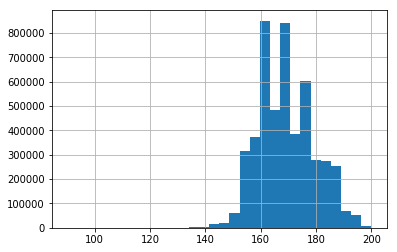

In [17]:
plt.figure()
height_raw.HEIGHT[(height_raw.HEIGHT<200) & (height_raw.HEIGHT>0) ].hist(bins=30)

### Weight data

In [18]:
weight_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_weight_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
weight_raw.head()

,MRN,WEIGHT_DATE,WEIGHT,PREGNANCY_INDICATOR
0,7695679,2006-01-27,62.60,1
1,7695679,2006-02-08,62.60,1
2,7695679,2006-02-08,62.60,1
3,7695679,2006-03-08,63.96,1
4,7695679,2006-10-02,65.77,1


Only take individuals with no pregnancy.

In [19]:
weights_nonpreg = weight_raw[weight_raw.PREGNANCY_INDICATOR==0].drop('PREGNANCY_INDICATOR', axis=1)

In [20]:
weight_counts = weights_nonpreg.groupby('MRN')['WEIGHT_DATE'].count()

In [21]:
MIN_MEASUREMENTS = 5
min_weights = weight_counts[weight_counts>=MIN_MEASUREMENTS].index.values

In [22]:
filtered_weights = weights_nonpreg[weights_nonpreg.MRN.isin(min_weights)]

In [23]:
assert not filtered_weights.isnull().sum().any()

Apply Greevy flagging algorihtm

In [24]:
from scipy.stats import chi2

def calc_concordance(patient, m=-0.032, sd=3.52):
    p = []
    nobs = min(11, patient.shape[0])
    for i,x in patient.iterrows():

        # Calculate deltas
        df = (pd.DataFrame({'uid':i, 
                           'delta_W':patient.WEIGHT - x.WEIGHT, 
                           'delta_T':(patient.WEIGHT_DATE - x.WEIGHT_DATE).dt.days.abs()})
             .sort_values('delta_T')[1:nobs]
             .assign(measurement=np.arange(1, nobs), weight_date=x.WEIGHT_DATE))
            
        # Calculate statistic
        prob = 1 - chi2.cdf(((df.delta_W - m)/sd) ** 2, 1) 

        # Convert to concordance probability
        p.append({'uid':i, 'p':prob.mean()})


    return pd.DataFrame(p).set_index('uid')


In [25]:
grouped = filtered_weights.groupby('MRN')

dflist = [group for name, group in grouped]

In [26]:
from ipyparallel import Client
rc = Client()
lview = rc.load_balanced_view()
lview.block = True

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [27]:
parallel_groups = lview.map(calc_concordance, dflist)

NameError: name 'lview' is not defined

In [28]:
recalculate_weights = False

if recalculate_weights:
    progress.pandas(desc='concordance probability calculation')
    concordance = (filtered_weights.groupby('MRN')
                   .progress_apply(calc_concordance))
    concordance.to_csv(CLEAN_DATA_DIR+'concordance.csv')
    # Add a relative date (to first measurement) of each measurement
    concordance.index = concordance.index.droplevel('MRN')
else:
    concordance = pd.read_csv(CLEAN_DATA_DIR+'concordance.csv', index_col=0)

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [29]:
concordance.head()

,uid,p
MRN,,
49858,2628853,0.129230
49858,2628854,0.274433
49858,2628855,0.344936
49858,2628856,0.708973
49858,2628857,0.745681


In [30]:
filtered_weights.query('MRN==49858')

,MRN,WEIGHT_DATE,WEIGHT
2628853,49858,2013-05-03,63.50
2628854,49858,2013-02-02,65.80
2628855,49858,2012-10-29,66.93
2628856,49858,2010-08-23,67.00
2628857,49858,2010-08-22,67.20
2628858,49858,2010-08-22,67.22
2628859,49858,2010-08-21,67.36
2628860,49858,2010-08-21,67.40
2628861,49858,2010-08-24,67.40
2628862,49858,2009-04-11,67.50


In [31]:
(concordance.p<0.01).mean()

0.0047287468770074569

In [32]:
concordance.shape

(5917001, 2)

Proportion excluded as a function of concordance threshold.

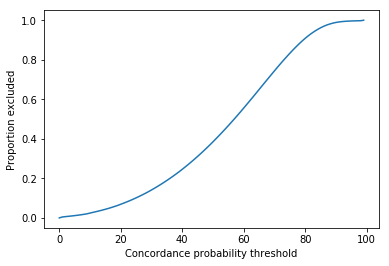

In [33]:
plt.figure()
plt.plot([(concordance.p<p).mean() for p in np.linspace(0, 1, 100)])
plt.xlabel('Concordance probability threshold')
plt.ylabel('Proportion excluded');

Merge concordance probabilities

In [34]:
weights = filtered_weights.merge(concordance, left_index=True, right_on='uid')

In [35]:
weights['Weight_filtered'] = weights.WEIGHT.copy()
weights.loc[weights.p<0.05, 'Weight_filtered'] = np.nan

Add age to each measurement

In [36]:
weights = weights.merge(demographics[['DOB']], left_on='MRN', right_index=True)
weights['AGE'] = (weights.WEIGHT_DATE - weights.DOB).astype('<m8[Y]')

Calculate BMI

In [37]:
bmi = weights.merge(height_raw, left_on=['MRN', 'WEIGHT_DATE'], 
              right_on=['MRN', 'HEIGHT_DATE'])
bmi['BMI'] = bmi.Weight_filtered / (bmi.HEIGHT / 100)**2

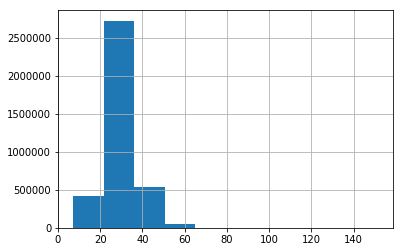

In [38]:
bmi.BMI.hist()

Confirm no missing p's

In [39]:
bmi.p.notnull().mean()

1.0

In [40]:
bmi.drop(['uid', 'p'], axis=1).to_csv(CLEAN_DATA_DIR+'bmi_full.csv')

In [41]:
del weights
del weight_raw
del weights_nonpreg
del weight_counts
del filtered_weights
del height_raw

Pivot table of weight by date and patient

In [42]:
bmi_by_patient = pd.pivot_table(bmi, 
                        index='WEIGHT_DATE', columns='MRN', values='BMI')

In [43]:
del bmi

In [44]:
bmi_by_patient.head()

MRN,49858,76216,171892,361972,390393,428169,443465,472613,509554,544221,...,95586095,95657524,95805263,96044581,96115373,96193156,96224647,96447065,96505185,96796297
WEIGHT_DATE,,,,,,,,,,,,,,,,,,,,,
1999-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Resample to monthly

In [45]:
monthly_bmi = bmi_by_patient.resample('M').median()

In [46]:
monthly_bmi.tail()

MRN,49858,76216,171892,361972,390393,428169,443465,472613,509554,544221,...,95586095,95657524,95805263,96044581,96115373,96193156,96224647,96447065,96505185,96796297
WEIGHT_DATE,,,,,,,,,,,,,,,,,,,,,
2016-08-31,NaN,NaN,18.428992,NaN,22.699637,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.643997,NaN
2016-09-30,NaN,NaN,NaN,NaN,22.147107,NaN,29.977796,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,29.914396,NaN,NaN,NaN,NaN
2016-10-31,NaN,NaN,18.883094,NaN,22.287602,NaN,29.681534,NaN,NaN,25.790374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.416899,33.643997,NaN
2016-11-30,NaN,NaN,NaN,NaN,21.557696,NaN,NaN,NaN,NaN,25.790374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,NaN,NaN,NaN,NaN,20.800628,NaN,29.535031,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
del bmi_by_patient

In [48]:
def shift_null(x):
    first_notnull = x[x.notnull()].index.min()
    return x.shift(-first_notnull)

In [49]:
def shift_null_array(x):
    first_non_null = np.nonzero(~np.isnan(x))[0][0]
    shifted = x[first_non_null:]
    x_shifted = np.full_like(x, np.nan) 
    x_shifted[:len(shifted)] = shifted
    return x_shifted

In [50]:
bmi_shifted = np.array([shift_null_array(x) for x in monthly_bmi.values.T])

In [51]:
first_2yrs = bmi_shifted[:, :24]

In [52]:
subset_2yrs = pd.DataFrame(first_2yrs, index=monthly_bmi.columns)
subset_2yrs.shape

(194414, 24)

In [53]:
subset_2yrs_min5 = subset_2yrs[subset_2yrs.notnull().sum(axis=1) > 4]

In [54]:
subset_2yrs_min5.to_csv(CLEAN_DATA_DIR+'subset_2yrs.csv')

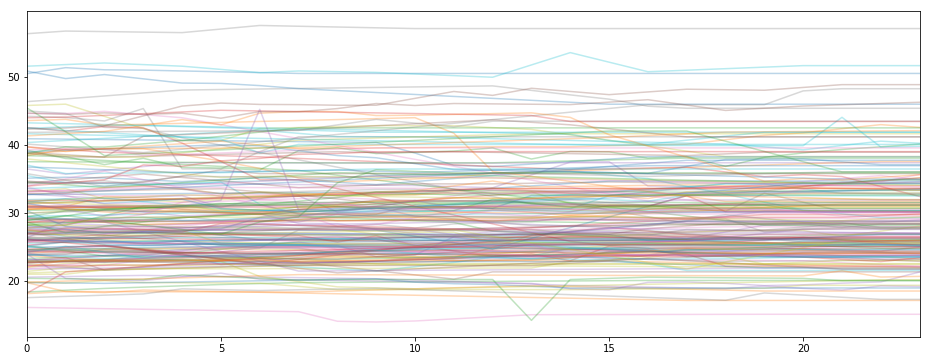

In [55]:
(pd.DataFrame(subset_2yrs_min5.values[np.random.choice(np.arange(len(subset_2yrs_min5)), 200)]).T.interpolate()
                    .plot(legend=False, alpha=0.3, figsize=(16,6)))

---

In [57]:
import sys

def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # for pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        # work around for a bug
        elif isinstance(v,pd.Panel):
            v = v.values
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.3fMB"%(value/1e6))
        total += value
    print("%.3fMB"%(total/1e6))

In [58]:
show_mem_usage()

['_', '_', '_56', '_56'] 3.783MB
['demographics', 'demographics'] 114.229MB
['flagged_demographics', 'flagged_demographics'] 201.055MB
['dflist'] 3.013MB
['concordance', 'concordance'] 142.008MB
['_44', '_44'] 7.777MB
['monthly_bmi', 'monthly_bmi'] 318.841MB
['_46', '_46'] 7.777MB
['bmi_shifted'] 318.839MB
['subset_2yrs', 'subset_2yrs'] 44.126MB
['subset_2yrs_min5', 'subset_2yrs_min5'] 14.523MB
1175.991MB
